#### Importing libraries and defining functions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def LF_step(q,p,a,dt,i,**kwargs):
    q_mid = q[i] + p[i]*dt/2
    p[i+1] = p[i] + a(q_mid,**kwargs)*dt
    q[i+1] = q_mid + p[i+1]*dt/2

def LFTT_step(W,t,q,p,a,dt,i,**kwargs):
    q_mid = q[i] + p[i]*(dt/2)/W[i]
    t_mid = t[i] + (dt/2)/W[i]
    q_mid_mag = np.linalg.norm(q_mid)
    p[i+1] = p[i] + a(q_mid,**kwargs)*dt*q_mid_mag
    W[i+1] = W[i] - np.dot(q_mid, ((p[i+1] + p[i])/2))*dt*(q_mid_mag**-2)
    q[i+1] = q_mid + p[i+1]*(dt/2)/W[i+1]
    t[i+1] = t_mid + (dt/2)/W[i+1]


GM_s = 4*(np.pi**2) # the GM values for sun in AU^3 year^-2
plt.rcParams['ytick.labelsize'] = 8


def gravity(r,GM=GM_s,delta=0,lamb=0):
    if lamb == 0: return - GM*r/(np.linalg.norm(r)**(3+delta))
    else: 
        r_mag = np.linalg.norm(r)
        return -GM*r*(r_mag**-(3+delta) + lamb*r_mag**-(5+delta))

def Orbit(
    GM=GM_s,
    r_init=np.array([1.017, 0.0]),
    v_init=np.array([0.0,6.179]),
    methods = {"LF":0.001},
    deltas =[0],
    lambs = [0],
    T_max = 5, # years
    a = gravity,
    vis=False
    ):
    if vis:
        fig = plt.figure(figsize=(10,20))
        AX = fig.subplots(15,1,sharex=True)
        fig2 = plt.figure()
        AX2 = fig2.subplots(1,1)
        colors = ["blue","red","green","black","purple","yellow","brown"][::-1]

    for delta in deltas:
        for method, dt in methods.items():
            for lamb in lambs:
                c = colors.pop()
                t = np.arange(0,T_max+dt/2,dt)
                r = np.zeros((t.shape[0],2))
                v = np.zeros((t.shape[0],2))
                r[0] = r_init
                v[0] = v_init
                if method=="LF":
                    for i in range(t.shape[0]-1):
                        LF_step(r,v,gravity,dt,i,lamb=lamb,delta=delta)
                elif method=="LFTT":
                    W = np.zeros_like(t)
                    W[0] = 1/np.linalg.norm(r_init)
                    for i in range(t.shape[0]-1):
                        LFTT_step(W,t,r,v,gravity,dt,i,lamb=lamb,delta=delta)
                else: raise ValueError(f"unknown method: {method}")
                x = r[:,0]
                y = r[:,1]
                v_x = v[:,0]
                v_y = v[:,1]
                theta = np.arctan2(y,x)
                theta = theta + 2*np.pi*(theta <  0)
                r = (x**2 + y**2)**0.5
                v = (v_x**2 + v_y**2)**0.5
                E = 0.5*v**2 - GM/(r*(1+delta))
                L = x*v_y - y*v_x
                A_x,A_y = [L*v_y -GM*x/r,-L*v_x -GM*y/r]
                A = (A_x**2 + A_y**2)**0.5
                phi = np.arctan2(A_y,A_x)
                phi = 2*np.pi*(phi < 0) + phi
                v_r = (x*v_x + y*v_y)/r
                v_theta = (-y*v_x + x*v_y)/r
                omega = v_theta/r
                a = ((2/r) - ((v**2)/GM))**-1
                T = 2*np.pi*((a**3)/GM)**0.5 
                r_prev = np.concatenate((r[:1],r[:-1]))
                r_next = np.concatenate((r[1:],r[-1:]-1e-12))
                i_r = np.flatnonzero((r < r_prev) & (r <= r_next))
                theta_prev = np.concatenate((theta[:1],theta[:-1]))
                theta_next = np.concatenate((theta[1:],theta[-1:]))
                i_theta = np.flatnonzero((theta < theta_prev) & (theta <= theta_next))
                n_r = np.zeros_like(t,dtype=int)
                for i in i_r :
                    n_r = n_r + (np.arange(t.shape[0]) >= i)
                n_theta = np.zeros_like(t,dtype=int)
                for i in i_theta :
                    n_theta = n_theta + (np.arange(t.shape[0]) >= i)
                if not vis:continue
                cond = (
                    f"({method}, " +
                    r"$\delta={" + str(delta)+ 
                    r"}$, $\Delta t=" + str(dt) + 
                    r"$, $\lambda=" + str(lamb)+"$)")
                AX[0].plot(t,v_x,label=cond,color=c) 
                AX[1].plot(t,v_y,label=cond,color=c)
                AX[2].plot(t,theta,label=cond,color=c)
                AX[2].plot(t[i_theta],theta[i_theta],'o',label="minima " + cond,color=c)
                AX[3].plot(t,r,label=cond,color=c)
                AX[3].plot(t[i_r],r[i_r],'o',label="minima " + cond,color=c)
                AX[4].plot(t,v,label=cond,color=c)
                AX[5].plot(t,v_r,label=cond,color=c)
                AX[6].plot(t,omega,label=cond,color=c)
                AX[7].plot(t,n_r,label=cond,color=c)
                AX[8].plot(t,n_theta,label=cond,color=c)
                AX[9].plot(t,E,label=cond,color=c)
                AX[10].plot(t,L,label=cond,color=c)
                AX[11].plot(t,A,label=cond,color=c)
                AX[12].plot(t,phi,label=cond,color=c)
                AX[13].plot(t[i_r],theta[i_r],'-o',label=cond)
                AX[14].plot(t[i_theta+1], (n_r[i_theta+1]/n_theta[i_theta+1]),label=cond)

                AX2.plot(x,y,label=cond,color=c)
                AX2.plot(x[0],y[0],'o',label="initial position" + cond,color=c)

    if vis:
        AX[2].set_ylim(0,2*np.pi)
        AX[2].set_yticks([0,2*np.pi],[0,r"$2\pi$"])
        AX[2].legend()
        AX[7].legend()
        AX[8].legend()
        AX[12].set_ylim(0,2*np.pi)
        AX[12].set_yticks([0,2*np.pi],[0,r"$2\pi$"])
        AX[13].set_ylim(0,2*np.pi)
        AX[13].set_yticks([0,2*np.pi],[0,r"$2\pi$"])
        ylabels = ["v_x","v_y",r"\theta","r","v","v_r",r"\omega",r"n_r",r"n_\theta",r"E/m",r"L/m",r"A/m^2",r"\phi",
        r"\theta_{r_{min}}",r"n_r/n_\theta"]
        for ax,lbl in zip(AX,ylabels): 
            ax.set_ylabel("$" + lbl + "$")
            # ax.legend()

        # AX[12].set_xlabel("$t$ (years)")
        AX[12].legend()
        AX[13].legend()
        AX[14].legend()
        AX[14].set_xlabel(r"$t$ (years)")

        AX2.set_xlabel("$x$ (AU)")
        AX2.set_ylabel("$y$ (AU)")
        AX2.plot([0],[0],'o',label="sun",color="yellow",markersize=10)
        AX2.axhline(0)
        AX2.axvline(0)
        AX2.set_aspect('equal')
        AX2.set_xlim(-0.1-np.linalg.norm(r_init),0.1+2*np.linalg.norm(r_init))
        AX2.set_ylim(-0.1-np.linalg.norm(r_init),0.1+2*np.linalg.norm(r_init))
        AX2.legend()

## Mini-Project 1 : Closed and Open Orbits in Modified Gravity

### Parts 1 and 2: Earth-Sun system with standard LF

For a given accelleration $\vec a(\vec q)$, the position-verlet LF integrator does :

$$
\vec q_{t+\Delta t/2} = \vec q_{t} + \vec p_t \Delta t/2 \\
\vec p_{t+\Delta t} = \vec p_{t} + \vec a(\vec q_{t+\Delta t/2})\Delta t\\
\vec q_{t} = \vec q_{t+\Delta t/2} + \vec p_{t+\Delta t} \Delta t/2 
$$

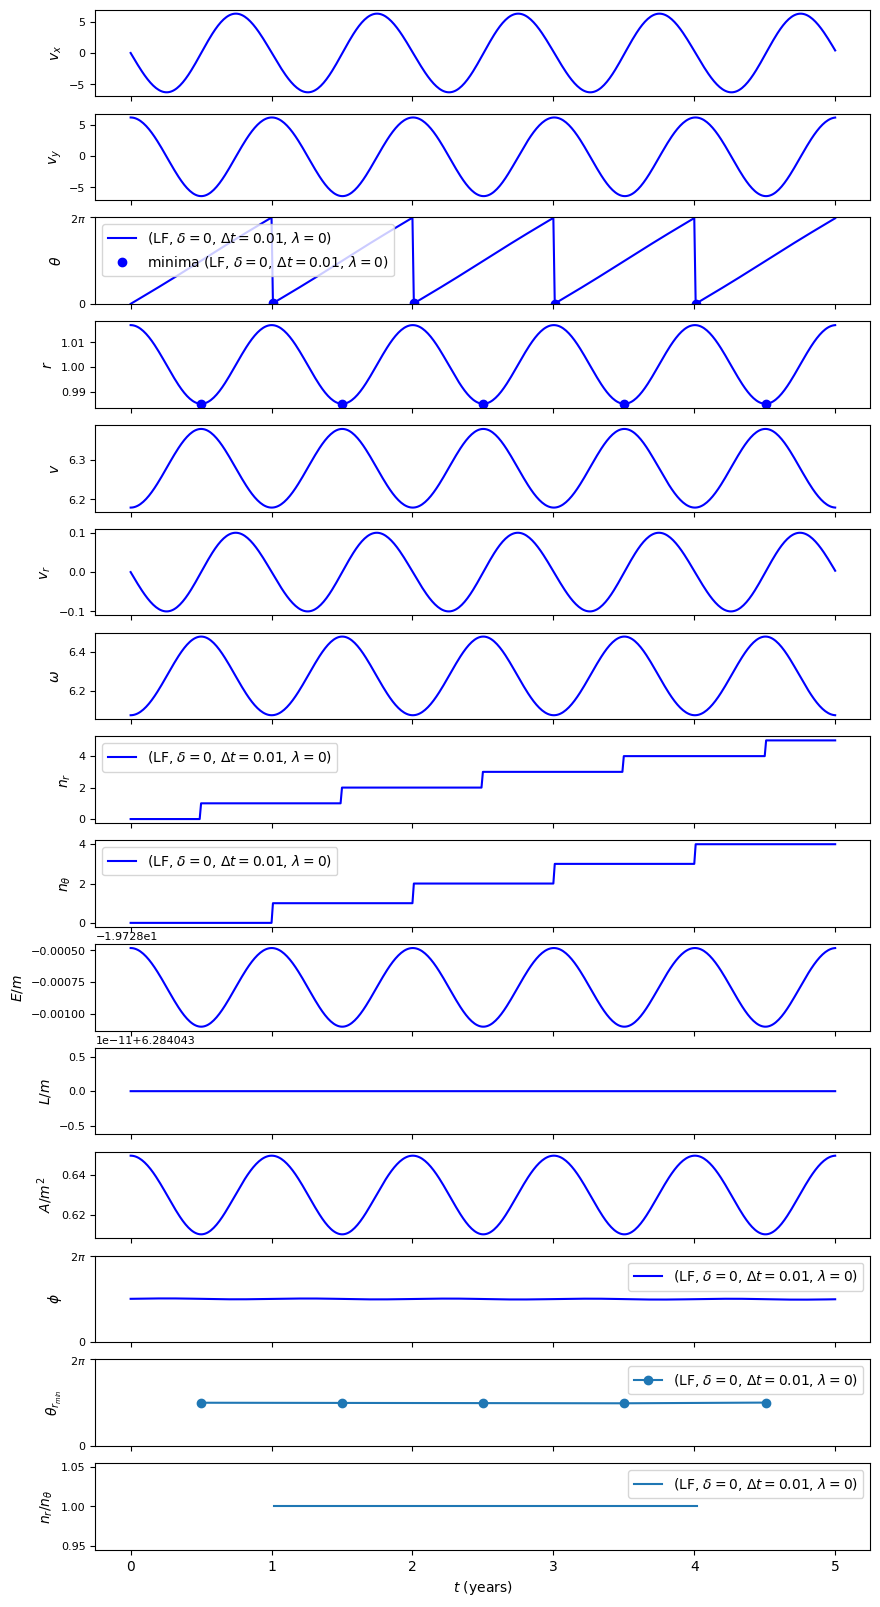

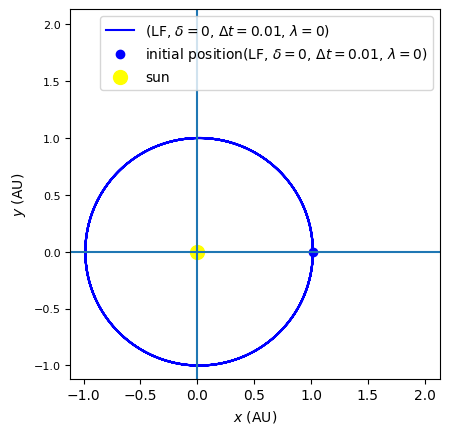

In [45]:
Orbit(vis=True,T_max=5,deltas=[0],methods={"LF":0.01},
    r_init=np.array([1.017, 0.0]), # AU
    v_init=np.array([0.0,6.179]) # AU/year
)
plt.show()

### Parts 3 and 4 : Closed Orbits

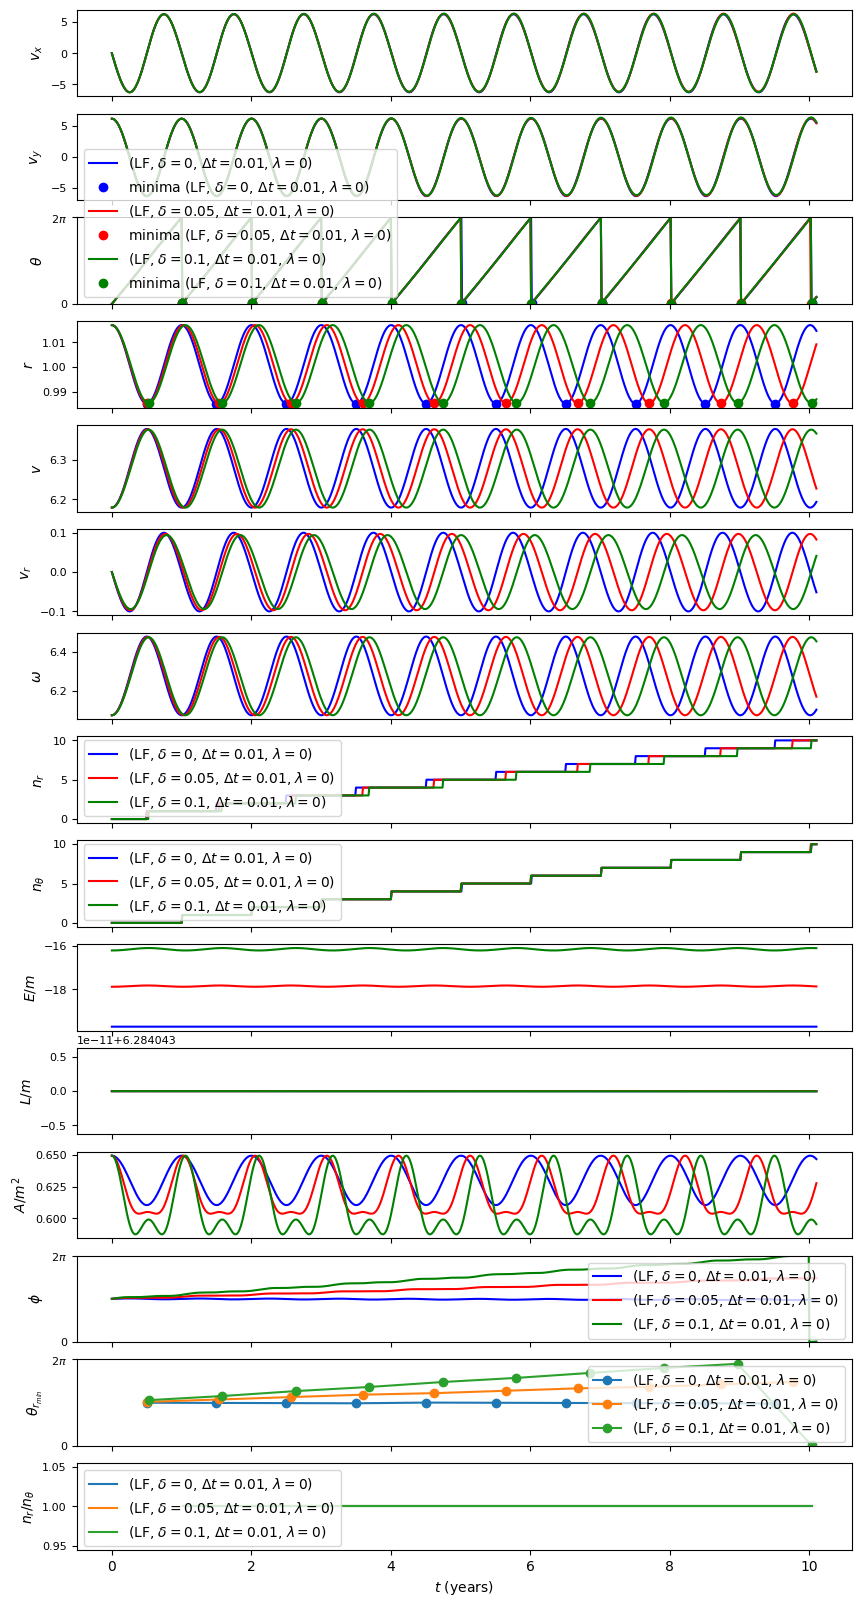

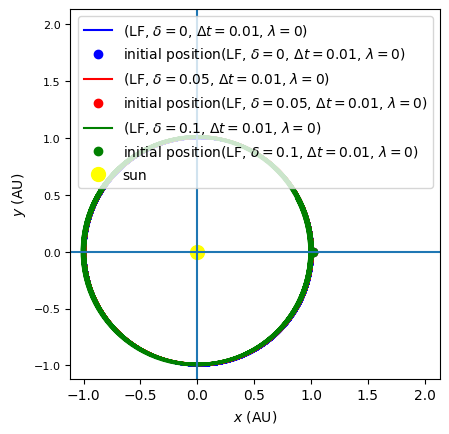

In [46]:
Orbit(vis=True,T_max=10.1,deltas=[0,0.05,0.1],methods={"LF":0.01},
    r_init=np.array([1.017, 0.0]), # AU
    v_init=np.array([0.0,6.179]) # AU/year
)
plt.show()

Defining perihelion for a single revolution as the point where the minimum distance from the sun is reached, we can now see how the angle $\theta_{r_\text{min}}$ that this point lies on (reltive to x-axis) changes with revolutions/time. 

This effect is not visible in the plot for trajectory because the trajectory isn't all that elliptic.

The same effect is also seen in the angle $\phi$ which is the angle where the Rung-Lenz vector points.

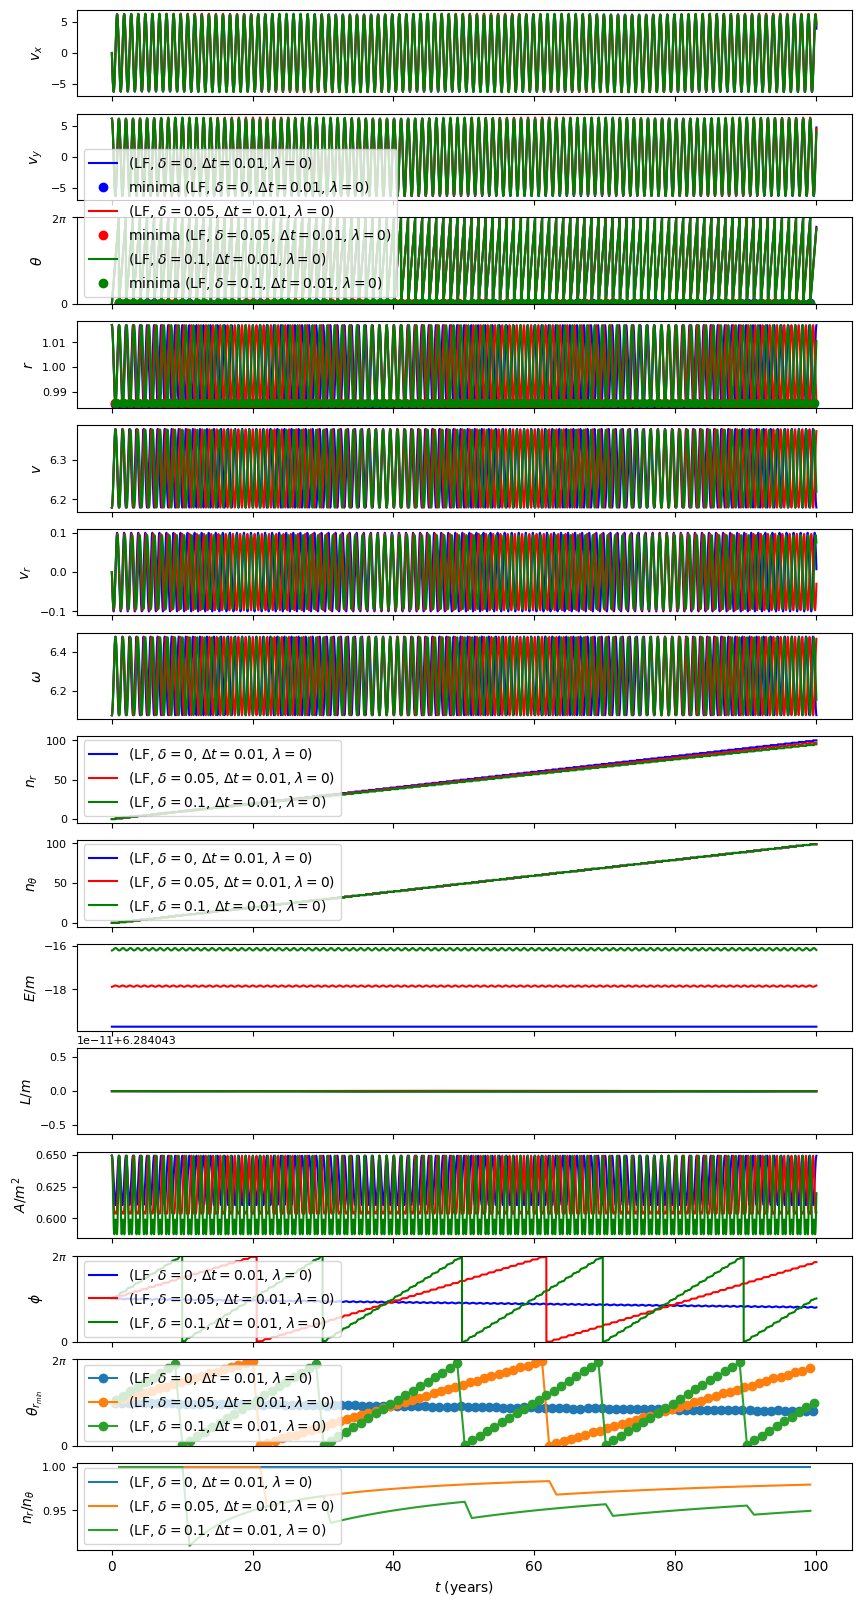

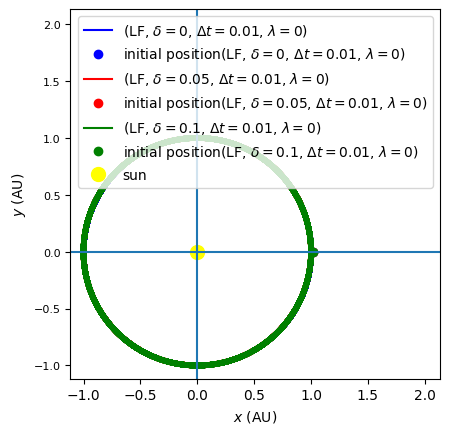

In [47]:
Orbit(vis=True,T_max=100.1,deltas=[0,0.05,0.1],methods={"LF":0.01},
    r_init=np.array([1.017, 0.0]), # AU
    v_init=np.array([0.0,6.179]) # AU/year
)
plt.show()

Take a look at the plot for $n_r/n_\theta$. You will see that the case with $\delta =0$ has no deviations, wherease others have very small (~0.05), but persistent deviation from the initial ratio of 1.